<a href="https://colab.research.google.com/github/sumeet/chess-deep-learning/blob/main/chess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utils

In [3]:
from torch.utils.data import random_split, DataLoader

def split_perc(dataset, percentages):
    total_data_len = len(dataset)
    split_lengths = [int(total_data_len * p) for p in percentages]
    
    # If there is any difference in sum, assign it to the last length
    sum_of_lengths = sum(split_lengths)
    if sum_of_lengths != total_data_len:
        split_lengths[-1] += total_data_len - sum_of_lengths
    
    return random_split(dataset, lengths=split_lengths)


# Input and outputs

In [15]:
# input:
#     [board position]

# output: (basically a move)
#     - src square
#     - dst square
#     - piece (rook, pawn, queen, etc.)


# training method:
#     - games from 2500+ rated players
#     - having the model try to learn moves made by the winner



try:
    import chess
    from chess import pgn
except ImportError:    
    !pip install python-chess
    import chess
    from chess import pgn

import torch
import torch.nn.functional as F
from torch import tensor

import gzip


PIECES_ORDER = ['pawn', 'knight', 'bishop', 'rook', 'queen', 'king']  # Chess piece types
PIECES = {name: i for i, name in enumerate(PIECES_ORDER)}

def board_to_tensors(board):
    tensor_board = torch.zeros((12, 8, 8), dtype=torch.float16)

    # Loop through all squares on the board
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            # Get piece type and color
            piece_type = chess.piece_name(piece.piece_type)
            color = piece.color

            # Calculate the coordinates
            row = square // 8
            col = square % 8

            # Calculate the depth index based on the piece type and color
            piece_index = PIECES[piece_type] + (6 if color == chess.BLACK else 0)

            # Place the piece in the tensor
            tensor_board[piece_index, row, col] = 1

    tensor_extras = torch.zeros(7, dtype=torch.float16)
    # Append castling rights
    tensor_extras[0] = int(board.has_kingside_castling_rights(chess.WHITE))
    tensor_extras[1] = int(board.has_queenside_castling_rights(chess.WHITE))
    tensor_extras[2] = int(board.has_kingside_castling_rights(chess.BLACK))
    tensor_extras[3] = int(board.has_queenside_castling_rights(chess.BLACK))

    # Append en passant square
    if board.ep_square is not None:
        tensor_extras[4] = board.ep_square
    else:
        tensor_extras[4] = 64

    # Append white's turn
    tensor_extras[5] = 1 if board.turn == chess.WHITE else 0

    # Append is in check
    tensor_extras[6] = 0 if board.is_check() else 1

    return (tensor_board, tensor_extras)


cache = {}
for i, src_file in enumerate('abcdefgh'):
    for j, src_rank in enumerate('12345678'):
        for k, dst_file in enumerate('abcdefgh'):
            for l, dst_rank in enumerate('12345678'):
                for piece_name in PIECES_ORDER:
                    # 128 for the board (8*8*2), 6 for the piece
                    t = torch.zeros(128+6, dtype=torch.float16)
                    src_index = i*8+j
                    dst_index = k*8+l
                    src_move = src_file + src_rank 
                    dst_move = dst_file + dst_rank
                    t[src_index] = 1.
                    t[64+dst_index] = 1.
                    piece_index = PIECES[piece_name]
                    t[128+piece_index] = 1.
                    cache[src_move+dst_move+piece_name] = t

def move_to_tensor(move: chess.Move, board_after: chess.Board):
    piece_name = chess.piece_name(board_after.piece_type_at(move.to_square))
    return cache[move.uci()[:4] + piece_name]


new_cache = {}
new_reverse_cache = []

for src_file in 'abcdefgh':
    for src_rank in '12345678':
        for dst_file in 'abcdefgh':
            for dst_rank in '12345678':
                movestr = src_file+src_rank+dst_file+dst_rank
                new_cache[movestr] = torch.tensor(len(new_reverse_cache))
                new_reverse_cache.append(movestr)



def move_to_tensor_new(move: chess.Move, board_after: chess.Board):
    return new_cache[move.uci()[:4]]


if 0:
    input_board_tensors = []
    input_extras_tensors = []
    output_tensors = []
    num_games = 0
    
    f = gzip.open('./drive/MyDrive/MLchess/output.chess.gz', 'rb')
    for line in f:
        moves = line.split(b",")
        winner = next(f).strip()
        if winner == b"D":
            continue
    
        to_move = b"W"
    
        board = chess.Board()
        for (i, move_san) in enumerate(moves):
            move_san = move_san.strip()
    
            # (was made by winner)
            use_as_input = to_move == winner and i < len(moves)
    
            if use_as_input:
                b, e = board_to_tensors(board)
                old_board = board.copy()
                input_board_tensors.append(b)
                input_extras_tensors.append(e)
    
            move = board.push_san(move_san.decode('utf-8'))
    
            if use_as_input:
                o = move_to_tensor(move, board)
                output_tensors.append(o)

            to_move = b"W" if to_move == b"B" else b"B"
    
        num_games += 1
    
        if num_games % 1000 == 0:
            print(f'processed {num_games} games already')
    
        # if num_games >= 1000:
        #     break
        if num_games >= 200_000:
            break
    
    
    print(f'loaded {len(input_board_tensors)} input  total')
    
        
    training_size = 100_000
    training_size = len(input_board_tensors)
    input_board_batch = torch.stack(input_board_tensors[:training_size])
    input_extras_batch = torch.stack(input_extras_tensors[:training_size])
    output_batch = torch.stack(output_tensors[:training_size])
    # output_src_batch = torch.stack(output_src_tensors[:training_size])
    # output_dst_batch = torch.stack(output_dst_tensors[:training_size])
    
    # test_input = torch.stack(input_sequences[training_size:])
    # test_output = torch.stack(output_sequences[training_size:])
    

# Save input/output tensors to filesystem

In [3]:
with gzip.open('./drive/MyDrive/MLchess/input_board_tensor.pt', 'wb') as f:
    torch.save(input_board_batch, f)
with gzip.open('./drive/MyDrive/MLchess/input_extras_tensor.pt', 'wb') as f:
    torch.save(input_extras_batch, f)
with gzip.open('./drive/MyDrive/MLchess/output_tensor.pt', 'wb') as f:
    torch.save(output_batch, f)

print(input_board_batch.shape)

torch.Size([7049592, 12, 8, 8])


# Load input/output tensors from filesystem

In [4]:
import torch
import gzip

with gzip.open('./drive/MyDrive/MLchess/input_board_tensor.pt', 'rb') as f:
    input_board_batch = torch.load(f)
with gzip.open('./drive/MyDrive/MLchess/input_extras_tensor.pt', 'rb') as f:
    input_extras_batch = torch.load(f)
with gzip.open('./drive/MyDrive/MLchess/output_tensor.pt', 'rb') as f:
    output_batch = torch.load(f)

print(input_board_batch.shape)


torch.Size([7049592, 12, 8, 8])


# Define Dataset

In [5]:
from torch.utils.data import TensorDataset

dataset = TensorDataset(input_board_batch,
                        input_extras_batch,
                        output_batch)

# Define Neural Network

In [12]:
import contextlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

# output format:
# [[1/64 src square][1/64 dst square][1/6 piece]]

class ChessMovePredictor(nn.Module):
    def __init__(self):
        super(ChessMovePredictor, self).__init__()
        # try: fully connected instead of convolutional
        self.conv1 = nn.Conv2d(12, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # 128*8*8 is the size of the flattened conv layer output,
        # and 7 is the size of the extra features tensor
        self.fc1 = nn.Linear(128*8*8 + 7, 256)  
        self.fc2 = nn.Linear(256, 256)  
        self.relu = nn.ReLU()
        self.fc_out = nn.Linear(256, 128+6)
        #self.fc_out = nn.Linear(512, 4096) # number of unique moves

    def forward(self, board_tensor, extra_features):
        out = F.relu(self.conv1(board_tensor))
        out = F.relu(self.conv2(out))
        out = out.view(out.size(0), -1)  # Flatten tensor
        out = torch.cat((out, extra_features), dim=1)  # Concatenate extra features
        out = self.relu(self.fc1(out))
        out = self.relu(self.fc2(out))
        out = self.fc_out(out)
        return out

    def run(self, dataloader, is_train):
        model = self.train() if is_train else self.eval()
        tot_loss = 0
        num_iterations = 0
    
        ctx = contextlib.nullcontext() if is_train else torch.no_grad()
        with ctx:
            for inputs_board, inputs_extras, targets in dataloader:
                inputs_board = inputs_board.to(device)
                inputs_extras = inputs_extras.to(device)
                targets = targets.to(device)
            
                # Forward pass
                with torch.cuda.amp.autocast():
                    outputs = model(inputs_board, inputs_extras)
            
                    targets_source, targets_dest, targets_square = targets[:, :64], targets[:, 64:128], targets[:, 128:]
                    outputs_source, outputs_dest, outputs_square = outputs[:, :64], outputs[:, 64:128], outputs[:, 128:]
                    loss_source = loss_fn(outputs_source, targets_source)
                    loss_dest = loss_fn(outputs_dest, targets_dest)
                    loss_square = loss_fn(outputs_square, targets_square)
                    # Compute total loss
                    loss = loss_source + loss_dest + loss_square
                    tot_loss += loss
                    num_iterations += 1

                if is_train:
                    # Backward pass and optimization
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()    
    
        return tot_loss / num_iterations


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ChessMovePredictor()
model = model.to(device)
loss_fn = nn.BCEWithLogitsLoss()
#loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Train Neural Network

In [13]:
from multiprocessing import cpu_count
from torch.utils.data import DataLoader, TensorDataset
import time

num_epochs = 10_000


if 1: # LOAD PREVIOUS MODEL FROM CHECKPOINT
    filename = './drive/MyDrive/MLchess/checkpoint.pt'
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])

training_set, validation_set = split_perc(dataset, [0.8, 0.2])

training_dataloader = DataLoader(training_set,
                        shuffle=True,
                        batch_size=10_000,
                        persistent_workers=True,
                        num_workers=cpu_count() - 1,
                        prefetch_factor=50,
                        pin_memory=True)
validation_dataloader = DataLoader(validation_set,
                        shuffle=True,
                        batch_size=10_000,
                        persistent_workers=True,
                        num_workers=cpu_count() - 1,
                        prefetch_factor=50,
                        pin_memory=True)

for epoch in range(num_epochs):
    epoch_start = time.time()

    training_loss = model.run(training_dataloader, is_train=True)
    validation_loss = model.run(validation_dataloader, is_train=False) 

    if epoch % 5 == 0:
        filename = './drive/MyDrive/MLchess/checkpoint.pt'
        print(f'checkpointing torch model & optimizer to {filename}')
        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'training_loss': training_loss,
            'validation_loss': validation_loss,
        }, filename)

    time_elapsed = time.time() - epoch_start
    print('Epoch [{}/{}], Training loss: {:.4f} Validation loss: {:.4f} ({} seconds)'
        .format(epoch+1, num_epochs, training_loss, validation_loss, time_elapsed))


checkpointing torch model & optimizer to ./drive/MyDrive/MLchess/checkpoint.pt
Epoch [1/10000], Training loss: 0.4190 Validation loss: 0.4175 (35.65623998641968 seconds)
Epoch [2/10000], Training loss: 0.4151 Validation loss: 0.4147 (30.943557739257812 seconds)
Epoch [3/10000], Training loss: 0.4117 Validation loss: 0.4132 (31.14259648323059 seconds)
Epoch [4/10000], Training loss: 0.4087 Validation loss: 0.4096 (30.945287942886353 seconds)
Epoch [5/10000], Training loss: 0.4062 Validation loss: 0.4105 (30.780170440673828 seconds)
checkpointing torch model & optimizer to ./drive/MyDrive/MLchess/checkpoint.pt
Epoch [6/10000], Training loss: 0.4040 Validation loss: 0.4073 (30.85460090637207 seconds)
Epoch [7/10000], Training loss: 0.4021 Validation loss: 0.4055 (31.350294828414917 seconds)
Epoch [8/10000], Training loss: 0.4003 Validation loss: 0.4038 (31.520118236541748 seconds)
Epoch [9/10000], Training loss: 0.3988 Validation loss: 0.4029 (31.77539372444153 seconds)
Epoch [10/10000], 

KeyboardInterrupt: ignored

# Play with AI

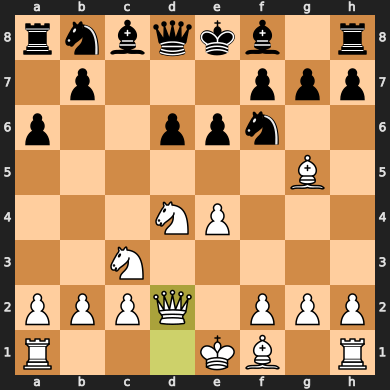

AI's turn
f8b5 pawn
Top 10 source squares:
Square 1 : f8 -0.8701171875
Square 2 : b7 -1.2060546875
Square 3 : h7 -1.390625
Square 4 : b8 -2.451171875
Square 5 : d8 -3.369140625
Square 6 : a7 -3.5
Square 7 : c8 -3.962890625
Square 8 : e6 -4.21484375
Square 9 : c7 -4.53515625
Square 10 : f6 -4.71484375
Top 10 destination squares:
Square 1 : b5 -0.94970703125
Square 2 : e7 -1.47265625
Square 3 : h6 -1.89453125
Square 4 : d7 -2.01953125
Square 5 : c6 -3.064453125
Square 6 : b6 -3.302734375
Square 7 : a6 -3.357421875
Square 8 : h5 -3.7265625
Square 9 : c7 -3.744140625
Square 10 : d6 -3.810546875
Top pieces:
Piece 1 : pawn -0.01036834716796875
Piece 2 : bishop -1.041015625
Piece 3 : knight -2.18359375
Piece 4 : queen -3.7265625
Piece 5 : rook -6.78125
Piece 6 : king -8.0078125


IllegalMoveError: ignored

In [22]:
try:
    import chess
except ImportError:
    !pip install python-chess
    import chess

from IPython.display import display, clear_output
#device = torch.device("cpu")
device = torch.device("cuda:0")

def print_topk_values(output, k=10):
    source_output, dest_output, piece_output = output[:, :64], output[:, 64:128], output[:, 128:]

    # Get the indices and values of the top-k values
    source_probs, source_indices = torch.topk(source_output, k)
    dest_probs, dest_indices = torch.topk(dest_output, k)
    piece_probs, piece_indices = torch.topk(piece_output, 6)
    
    print("Top", k, "source squares:")
    for i in range(k):
        # Convert the index back into file and rank
        source_square_index = source_indices[0][i].item()
        source_prob = source_probs[0][i].item()
        source_file = 'abcdefgh'[source_square_index // 8]
        source_rank = '12345678'[source_square_index % 8]
        # Print the source square
        print("Square", i+1, ":", source_file + source_rank, source_prob)

    print("Top", k, "destination squares:")
    for i in range(k):
        # Convert the index back into file and rank
        dest_square_index = dest_indices[0][i].item()
        dest_prob = dest_probs[0][i].item()
        dest_file = 'abcdefgh'[dest_square_index // 8]
        dest_rank = '12345678'[dest_square_index % 8]
        # Print the destination square
        print("Square", i+1, ":", dest_file + dest_rank, dest_prob)

    print("Top pieces:")
    for i in range(6):
        # Get the piece
        piece_index = piece_indices[0][i].item()
        piece_prob = piece_probs[0][i].item()
        # Print the piece
        print("Piece", i+1, ":", PIECES_ORDER[piece_index], piece_prob)

def output_to_move(output):
    source_output, dest_output, piece_output = output[:, :64], output[:, 64:128], output[:, 128:]

    # Get the index of the highest value in each half
    source_square_index = torch.argmax(source_output).item()
    dest_square_index = torch.argmax(dest_output).item()
    piece_index = torch.argmax(piece_output).item()
    
    # Convert the indices back into file and rank
    source_file = 'abcdefgh'[source_square_index // 8]
    source_rank = '12345678'[source_square_index % 8]
    dest_file = 'abcdefgh'[dest_square_index // 8]
    dest_rank = '12345678'[dest_square_index % 8]

    # Return the move as a string
    return PIECES_ORDER[piece_index], source_file + source_rank + dest_file + dest_rank


if 0:
    board = chess.Board()

def play(our_move):
    clear_output(wait=True)
    display(board)

    board.push_san(our_move)
    clear_output(wait=True)
    display(board)

    print("AI's turn")

    # Convert board state to model input
    input_tensor, input_extras = board_to_tensors(board)
    input_tensor = input_tensor.unsqueeze(0)
    input_extras = input_extras.unsqueeze(0)

    # Get the move from the model
    # source_output, dest_output = model(input_tensor.to(device), input_extras.to(device))
    with torch.cuda.amp.autocast():
        output = model(input_tensor.to(device), input_extras.to(device))

    # Convert model output to move
    piece, ai_move = output_to_move(output)
    print(ai_move, piece)
    print_topk_values(output)
        
    # Make the move on the board
    board.push_san(ai_move)

    clear_output(wait=True)
    display(board)
    print('AI move', ai_move, piece)
    print_topk_values(output)


play('d1d2')

# Optimize Neural Network Hyperparameters with Optuna

In [ ]:
try:
    import optuna
except ImportError:
    !pip install optuna
    import optuna

try:
    from sklearn.model_selection import train_test_split
except ImportError:
    !pip install scikit-learn
    from sklearn.model_selection import train_test_split

from torch.utils.data import random_split, DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

objective_dataset, _ = split_perc(dataset, [0.1, 0.9])
objective_train_dataset, objective_valid_dataset = split_perc(objective_dataset, [0.7, 0.3])


def objective(trial):
    # Define hyperparameters
    batch_size = trial.suggest_int('batch_size', 32, 131072, log=True)
    
    # Create model with these hyperparameters
    model = ChessMovePredictor()
    optimizer = torch.optim.Adam(model.parameters())
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Define dataset and dataloader with the chosen batch size
    train_dataloader = DataLoader(objective_train_dataset, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(objective_valid_dataset, batch_size=batch_size, shuffle=True)

    max_epochs = 100
    patience = 10
    best_val_loss = float("inf")
    counter = 0

    # Define your training loop here
    for epoch in range(max_epochs):
        model.run(train_dataloader, is_train=True)

        # Evaluate your model on validation data
        val_loss = model.run(valid_dataloader, is_train=False)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            # Increment the counter if no improvement is observed
            counter += 1

    # Stop training if the patience value is reached
        if counter >= patience:
            break

    return best_val_loss


study = optuna.create_study(direction="minimize")
study.optimize(objective) 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.2 MB/s eta 0:00:00


[I 2023-06-05 05:30:30,945] A new study created in memory with name: no-name-2142273f-5eda-4473-ba81-6dad7d139194
[I 2023-06-05 05:32:12,330] Trial 0 finished with value: 2.8246731758117676 and parameters: {'batch_size': 282}. Best is trial 0 with value: 2.8246731758117676.
[W 2023-06-05 05:34:38,703] Trial 1 failed with parameters: {'batch_size': 404} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-4-f67c3040aae4>", line 99, in objective
    val_loss = run(model, valid_dataloader, is_train=False)
  File "<ipython-input-4-f67c3040aae4>", line 45, in run
    for inputs_board, inputs_extras, targets in dataloader:
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 633, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.10/dist-packages/tor

KeyboardInterrupt: ignored

# Free up memory

In [ ]:
try:
    del dataset
    del dataloader
    del input_batch
    del output_batch
except NameError:
    pass
torch.cuda.empty_cache()

input = test_input.to(device)
output = model(input)
loss_fn(output, test_output.to(device))


tensor(0.0683, device='cuda:0', grad_fn=<NllLossBackward0>)